In [2]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [3]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
from sklearn.neighbors import NearestNeighbors

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
n_pc_samples = 2048
loss = 'emd'
experiment_name = 'all_snc_rotated_conv_arch_2048pts_' + loss
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()

conf.allow_gpu_growth = True
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]

ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 2000.


In [494]:
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
print syn_id

Give me the class type.
car
02958343


In [495]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

full_pclouds_path = osp.join(full_pclouds_path, syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)

In [496]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=full_model_names, init_shuffle=False)

_, latent_emb, _ = latent_embedding_of_entire_dataset(train_data, ae, conf)
n_objects = train_data.num_examples

7497 files containing complete point clouds were found.


In [497]:
nn = NearestNeighbors(n_neighbors=2).fit(latent_emb)

In [ ]:
# NOTES
# model = EMD_All_SNC (2K epochs, 512 bneck)
# Good Chair Triplets:
#   6366, 3710, 6487
#   2589, 6277, 4061

# Good Table Triplets:
#    7656, 1388, 4996
#    5935, 5576, 6128
#    953, 6003, 2403


In [587]:
def sample_analogy():
    while True:
        a, b, c = np.random.choice(n_objects, 3, replace=False)
        a = 4391
        b = 2746
#         c = 6266
        diff = latent_emb[b] - latent_emb[a]
        target = latent_emb[c] + diff
        _, index = nn.kneighbors(target.reshape(1, -1))
        d = index[0][0]
        triplet = np.array([a, b, c])
        if d in triplet:
            pass
        else:
            break

    analogy = triplet.tolist()
    analogy.append(d)
    return analogy

[4391, 2746, 4591, 6371]


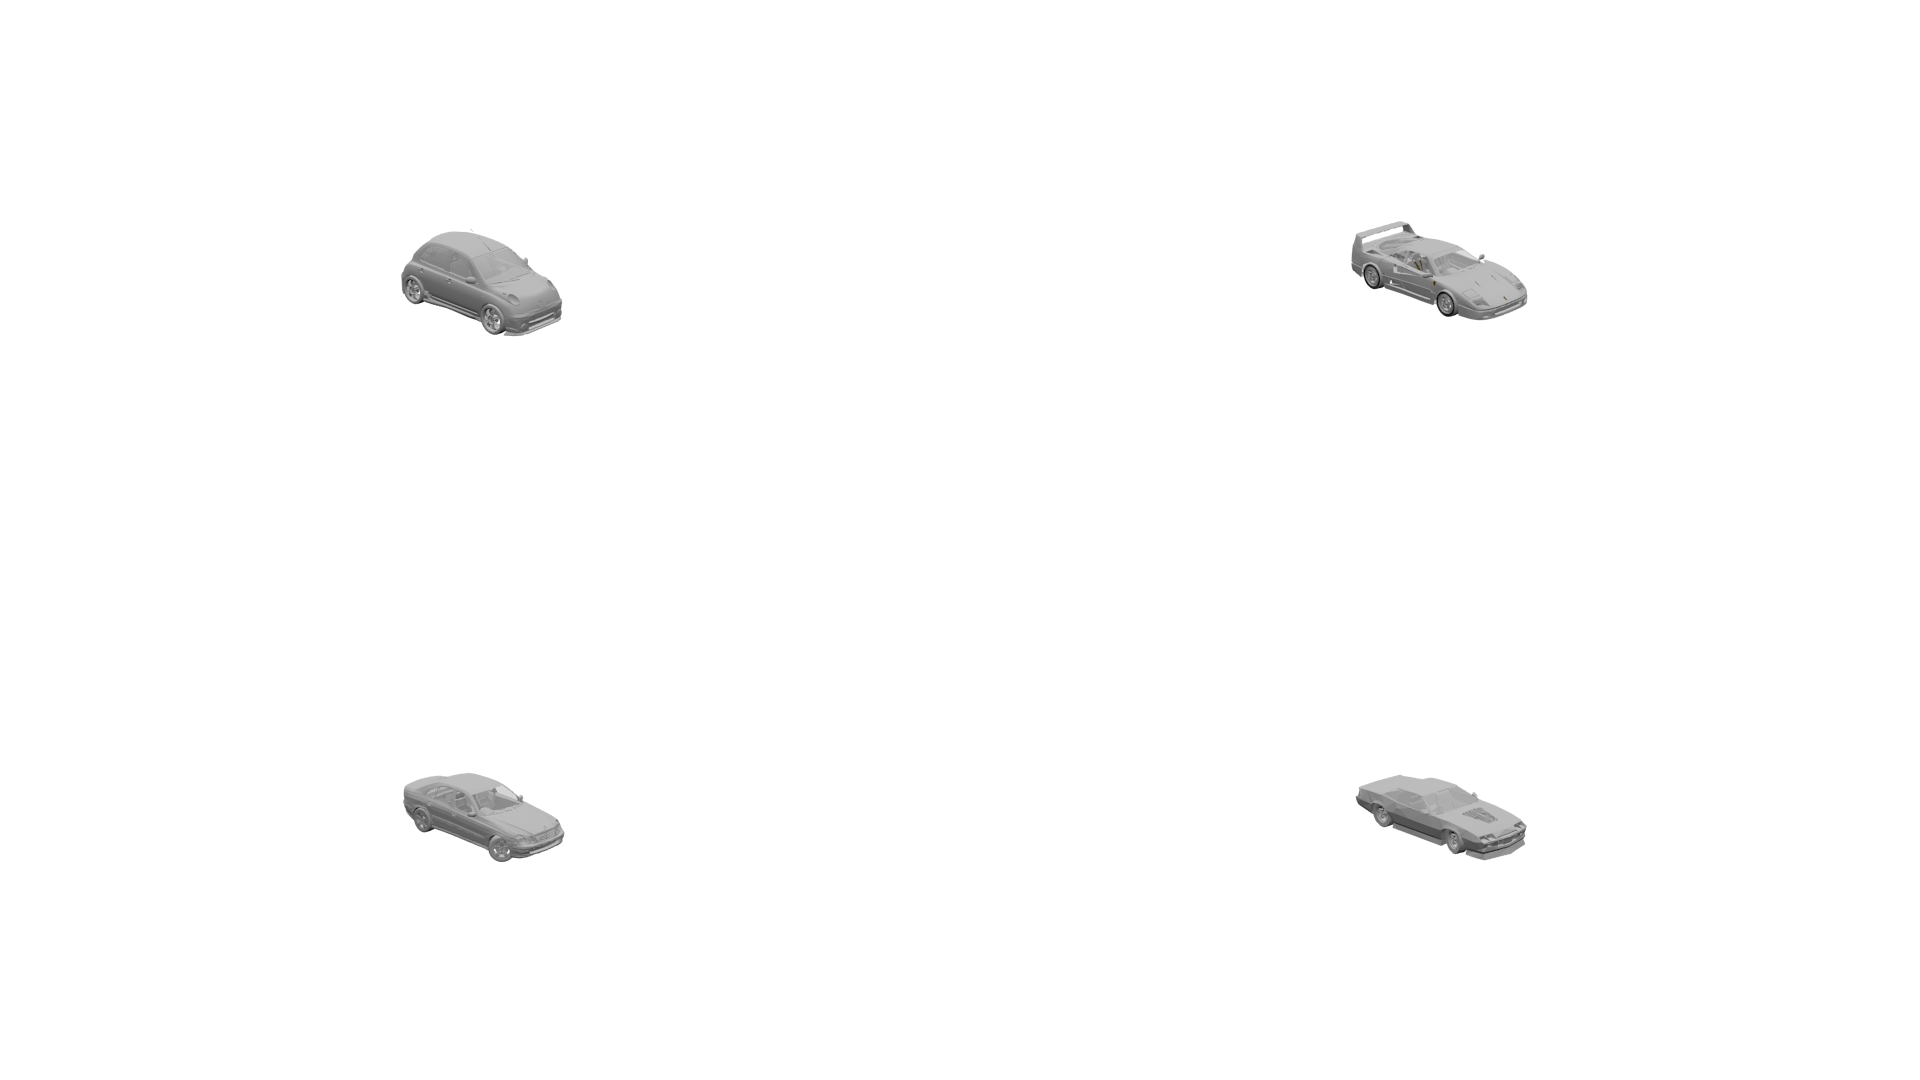

In [595]:
analogy = sample_analogy()

top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/' + syn_id
image_setting = 'image_p020_t315_r005.png'
triplet_im_files = [osp.join(top_image_dir, i, image_setting) for i in full_model_names[analogy]]

print analogy
stack_images_in_square_grid(triplet_im_files) 